Baseline_TF
https://www.kaggle.com/code/ivaneleskin/baseline-tf

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import json
import gc
from sklearn.model_selection import train_test_split
# import missingno as msno

from pathlib import Path

2023-03-01 10:57:21.337962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 10:57:21.488165: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-01 10:57:21.934515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/
2023-03-01 10:57:21.934579: W tensorflow/stream_executor/platfo

In [2]:
DATA_ROOT = Path('..')
DF_TRAIN = DATA_ROOT / 'train.csv'
train = pd.read_csv(DF_TRAIN)

print("train.shape = {} rows, {} cols".format(*train.shape))
train.info()
train.head()


train.shape = 94477 rows, 4 cols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [3]:
class CFG:
    data_path = "../"
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

In [4]:
train = pd.read_csv(f"{CFG.data_path}train.csv")
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])

In [5]:
MAX_FRAMES = 5
X_npy_fname = f'X_3d-avg-{MAX_FRAMES}_frames.npy'
y_npy_fname = f'y.npy'


if CFG.is_training:
    try:
        X = np.load(X_npy_fname)
        y = np.load(y_npy_fname)
    except:
        print('True')
        X = np.zeros((len(train), 543, 3))
        y = np.zeros((len(train),))
        num_frames = np.zeros(len(train))
        for i in tqdm(range(len(train))):
            path = f"{CFG.data_path}{train.iloc[i].path}"
            data = load_relevant_data_subset_with_imputation(path)
            ## Mean Aggregation
            data_resize = tf.image.resize(
                data,
                (MAX_FRAMES, 543),
                method='nearest',
            )
            X[i] = np.mean(data_resize, axis=0)
            y[i] = train.iloc[i].label
            num_frames[i] = data.shape[0]
            if CFG.quick_experiment and i == 4999:
                break
        ## Save number of frames of each training sample for data analysis
        train["num_frames"] = num_frames
        print(train["num_frames"].describe())
        train.to_csv("train.csv", index=False)
        np.save(X_npy_fname, X)
        np.save(y_npy_fname, y)

    print(X.shape, y.shape)

(94477, 543, 3) (94477,)


In [6]:
X.shape

(94477, 543, 3)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(75581, 543, 3) (75581,) (18896, 543, 3) (18896,)


|part|start|end|
|----|--|---|
|face| 0| 467|
|left_hand| 468| 488|
|pose| 489| 521|
|right_hand| 522| 542|

In [8]:
# inputs = tf.keras.Input((MAX_FRAMES, 543, 3), dtype=tf.float32)
# h1 = tf.keras.layers.Dense(128, activation="relu")(inputs)
# h1 = tf.keras.layers.Dense(128, activation="relu")(h1)
# h1 = tf.keras.layers.Dropout(0.2)(h1)
# h2 = tf.keras.layers.Dense(64, activation="relu")(h1)
# h2 = tf.keras.layers.Dense(64, activation="relu")(h2)
# h3 = tf.keras.layers.Dropout(0.2)(h2)

# concat = tf.keras.layers.Concatenate()([inputs, h3])
# vector = tf.keras.layers.Dense(64, activation="relu")(concat)
# vector = tf.keras.layers.Dense(64, activation="relu")(vector)
# vector = tf.keras.layers.Dropout(0.2)(vector)
# vector = tf.keras.layers.Flatten()(vector)
# output = tf.keras.layers.Dense(250, activation="softmax")(vector)


# model = tf.keras.Model(inputs=inputs, outputs=output)
# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     optimizer='adam',
#     metrics=[
#         'accuracy',
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top-05-acc'),
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top-10-acc'),
#     ]
# )

In [9]:
# tf.keras.layers.Lambda(lambda x: x[:, 0:  468, :]) #face
# tf.keras.layers.Lambda(lambda x: x[:, 468:489, :]) #left_hand
# tf.keras.layers.Lambda(lambda x: x[:, 489:522, :]) #pose
# tf.keras.layers.Lambda(lambda x: x[:, 522:542, :]) #right_hand

In [10]:
# N_FACE_PTS = 468
# N_HAND_PTS = 21
# N_POSE_PTS = 20


# input_left = tf.keras.layers.Input(shape=(N_HAND_PTS,))
# input_right = tf.keras.layers.Input(shape=(N_HAND_PTS,))
# input_face = tf.keras.layers.Input(shape=(N_FACE_PTS,))
# input_pose = tf.keras.layers.Input(shape=(N_POSE_PTS,))


# head_avg = tf.keras.layers.Lambda(
#     lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(input_face)

# # Get just the left hand + avg head
# left_head_avg = tf.keras.layers.Concatenate()([input_left, head_avg])

# # Get just the right hand + avg head
# right_head_avg = tf.keras.layers.Concatenate()([input_right, head_avg])



# x1 = tf.keras.layers.Dense(8, activation='relu')(input1)
# input2 = tf.keras.layers.Input(shape=(32,))
# x2 = tf.keras.layers.Dense(8, activation='relu')(input2)
# avg = tf.keras.layers.Average()([x1, x2])
# out = tf.keras.layers.Dense(4)(avg)
# model = tf.keras.models.Model(inputs=[input1, input2], outputs=out)

In [11]:
# inputs = tf.keras.Input((543, 3), dtype=tf.float32)
# h1 = tf.keras.layers.Dense(128, activation="relu")(inputs)
# h2 = tf.keras.layers.Dense(64, activation="relu")(h1)
# h3 = tf.keras.layers.Dense(64, activation="relu")(h2)
# 
# concat = tf.keras.layers.Concatenate()([inputs, h3])
# vector = tf.keras.layers.Dense(64, activation="relu")(concat)
# vector = tf.keras.layers.Dense(32, activation="relu")(vector)
# vector = tf.keras.layers.Dense(32, activation="relu")(vector)
# vector = tf.keras.layers.Flatten()(vector)
# output = tf.keras.layers.Dense(250, activation="softmax")(vector)

# model = tf.keras.Model(inputs=inputs, outputs=output)
# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
#     metrics=[
#         "accuracy",
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-5-accuracy"),
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10),
#     ]
# )

In [12]:
# model = tf.keras.Sequential([
# #     tf.keras.layers.ConvLSTM1D(128, kernel_size=2, return_sequences=True, input_shape=[None, 543, 3]),
# #     tf.keras.layers.ConvLSTM1D(128, kernel_size=2,),
#     tf.keras.layers.GRU(256, return_sequences=True, input_shape=(None, 3)),
#     tf.keras.layers.GRU(256),
#     tf.keras.layers.Dense(256, activation="relu"),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(250, activation="softmax"),
# ])

# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
#     optimizer='adam',
#     metrics=[
#         "accuracy",
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-05-acc"),
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-acc"),
#     ]
# )

# model.summary()

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=(None, 3)),
    tf.keras.layers.GRU(128),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dense(64, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='softmax'),
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[
        "accuracy",
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top-05-acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top-10-acc"),
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, None, 128)         51072     
                                                                 
 gru_7 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 250)               32250     
                                                                 
Total params: 182,394
Trainable params: 182,394
Non-trainable params: 0
_________________________________________________________________


In [23]:
if True:
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint("model.h5"),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=6,
            restore_best_weights=True,
        ),
    ]
    history = model.fit(
        X_train,
        y_train,
        epochs=500,
        validation_data=(X_val, y_val),
        batch_size=(1024),
        callbacks=callbacks,
    )
else:
    model = tf.keras.models.load_model("../model.h5")

Epoch 1/500
74/74 [==============================] - 9s 92ms/step - loss: 5.4617 - accuracy: 0.0069 - top-05-acc: 0.0328 - top-10-acc: 0.0629 - val_loss: 5.3922 - val_accuracy: 0.0116 - val_top-05-acc: 0.0458 - val_top-10-acc: 0.0841
Epoch 2/500
74/74 [==============================] - 6s 85ms/step - loss: 5.3667 - accuracy: 0.0115 - top-05-acc: 0.0493 - top-10-acc: 0.0927 - val_loss: 5.3379 - val_accuracy: 0.0138 - val_top-05-acc: 0.0572 - val_top-10-acc: 0.1021
Epoch 3/500
74/74 [==============================] - 6s 85ms/step - loss: 5.2616 - accuracy: 0.0177 - top-05-acc: 0.0729 - top-10-acc: 0.1244 - val_loss: 5.2245 - val_accuracy: 0.0207 - val_top-05-acc: 0.0772 - val_top-10-acc: 0.1379
Epoch 4/500
74/74 [==============================] - 6s 84ms/step - loss: 5.1502 - accuracy: 0.0222 - top-05-acc: 0.0921 - top-10-acc: 0.1557 - val_loss: 5.1059 - val_accuracy: 0.0247 - val_top-05-acc: 0.0977 - val_top-10-acc: 0.1638
Epoch 5/500
74/74 [==============================] - 6s 83ms/ste

Epoch 36/500
74/74 [==============================] - 6s 86ms/step - loss: 3.6484 - accuracy: 0.1905 - top-05-acc: 0.4503 - top-10-acc: 0.5807 - val_loss: 3.7090 - val_accuracy: 0.1797 - val_top-05-acc: 0.4340 - val_top-10-acc: 0.5645
Epoch 37/500
74/74 [==============================] - 6s 83ms/step - loss: 3.6251 - accuracy: 0.1948 - top-05-acc: 0.4549 - top-10-acc: 0.5847 - val_loss: 3.6478 - val_accuracy: 0.1942 - val_top-05-acc: 0.4495 - val_top-10-acc: 0.5796
Epoch 38/500
74/74 [==============================] - 6s 84ms/step - loss: 3.5991 - accuracy: 0.1991 - top-05-acc: 0.4630 - top-10-acc: 0.5905 - val_loss: 3.6121 - val_accuracy: 0.2002 - val_top-05-acc: 0.4585 - val_top-10-acc: 0.5882
Epoch 39/500
74/74 [==============================] - 6s 85ms/step - loss: 3.5639 - accuracy: 0.2056 - top-05-acc: 0.4697 - top-10-acc: 0.5980 - val_loss: 3.6373 - val_accuracy: 0.1944 - val_top-05-acc: 0.4517 - val_top-10-acc: 0.5794
Epoch 40/500
74/74 [==============================] - 6s 85m

Epoch 71/500
74/74 [==============================] - 6s 87ms/step - loss: 2.9174 - accuracy: 0.3199 - top-05-acc: 0.6109 - top-10-acc: 0.7194 - val_loss: 3.1404 - val_accuracy: 0.2793 - val_top-05-acc: 0.5619 - val_top-10-acc: 0.6787
Epoch 72/500
74/74 [==============================] - 6s 87ms/step - loss: 2.9022 - accuracy: 0.3208 - top-05-acc: 0.6134 - top-10-acc: 0.7216 - val_loss: 3.0321 - val_accuracy: 0.2950 - val_top-05-acc: 0.5890 - val_top-10-acc: 0.6998
Epoch 73/500
74/74 [==============================] - 7s 89ms/step - loss: 2.8850 - accuracy: 0.3257 - top-05-acc: 0.6166 - top-10-acc: 0.7234 - val_loss: 3.0330 - val_accuracy: 0.3018 - val_top-05-acc: 0.5852 - val_top-10-acc: 0.6983
Epoch 74/500
74/74 [==============================] - 6s 87ms/step - loss: 2.8783 - accuracy: 0.3267 - top-05-acc: 0.6188 - top-10-acc: 0.7252 - val_loss: 3.0951 - val_accuracy: 0.2919 - val_top-05-acc: 0.5708 - val_top-10-acc: 0.6849
Epoch 75/500
74/74 [==============================] - 7s 88m

Epoch 106/500
74/74 [==============================] - 6s 88ms/step - loss: 2.4941 - accuracy: 0.4034 - top-05-acc: 0.6916 - top-10-acc: 0.7834 - val_loss: 2.8075 - val_accuracy: 0.3441 - val_top-05-acc: 0.6344 - val_top-10-acc: 0.7352
Epoch 107/500
74/74 [==============================] - 6s 87ms/step - loss: 2.4853 - accuracy: 0.4050 - top-05-acc: 0.6925 - top-10-acc: 0.7837 - val_loss: 2.7562 - val_accuracy: 0.3555 - val_top-05-acc: 0.6435 - val_top-10-acc: 0.7415
Epoch 108/500
74/74 [==============================] - 6s 87ms/step - loss: 2.4716 - accuracy: 0.4062 - top-05-acc: 0.6950 - top-10-acc: 0.7857 - val_loss: 2.7548 - val_accuracy: 0.3548 - val_top-05-acc: 0.6430 - val_top-10-acc: 0.7452
Epoch 109/500
74/74 [==============================] - 6s 88ms/step - loss: 2.4641 - accuracy: 0.4082 - top-05-acc: 0.6976 - top-10-acc: 0.7879 - val_loss: 2.7634 - val_accuracy: 0.3580 - val_top-05-acc: 0.6451 - val_top-10-acc: 0.7407
Epoch 110/500
74/74 [==============================] - 6

Epoch 141/500
74/74 [==============================] - 6s 85ms/step - loss: 2.2002 - accuracy: 0.4643 - top-05-acc: 0.7416 - top-10-acc: 0.8204 - val_loss: 2.6384 - val_accuracy: 0.3859 - val_top-05-acc: 0.6690 - val_top-10-acc: 0.7610
Epoch 142/500
74/74 [==============================] - 6s 83ms/step - loss: 2.1800 - accuracy: 0.4692 - top-05-acc: 0.7443 - top-10-acc: 0.8227 - val_loss: 2.6289 - val_accuracy: 0.3883 - val_top-05-acc: 0.6710 - val_top-10-acc: 0.7625
Epoch 143/500
74/74 [==============================] - 6s 82ms/step - loss: 2.1818 - accuracy: 0.4707 - top-05-acc: 0.7437 - top-10-acc: 0.8214 - val_loss: 2.6444 - val_accuracy: 0.3828 - val_top-05-acc: 0.6686 - val_top-10-acc: 0.7606
Epoch 144/500
74/74 [==============================] - 6s 85ms/step - loss: 2.1704 - accuracy: 0.4706 - top-05-acc: 0.7466 - top-10-acc: 0.8234 - val_loss: 2.6190 - val_accuracy: 0.3931 - val_top-05-acc: 0.6707 - val_top-10-acc: 0.7625


In [24]:
import matplotlib.pyplot as plt
import numpy as np

print(history.history.keys())

dict_keys(['loss', 'accuracy', 'top-05-acc', 'top-10-acc', 'val_loss', 'val_accuracy', 'val_top-05-acc', 'val_top-10-acc'])


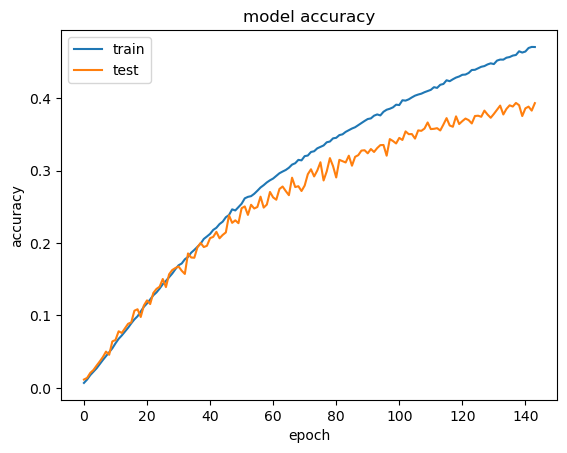

In [25]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

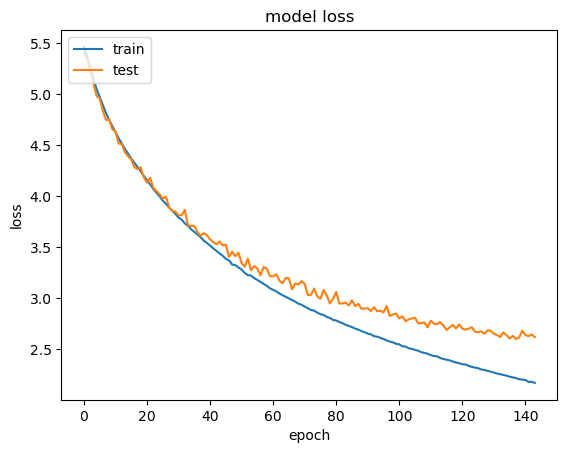

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
def get_model():
    return model

In [28]:
get_model().summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, None, 128)         51072     
                                                                 
 gru_7 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 250)               32250     
                                                                 
Total params: 182,394
Trainable params: 182,394
Non-trainable params: 0
_________________________________________________________________


In [29]:
inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
x = tf.reduce_mean(x, axis=0, keepdims=True)

# for i in range(1, len(model.layers)):
x = model.layers[0](x)
x = model.layers[1](x)
x = model.layers[2](x)

In [30]:
def get_inference_model(model):
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
    x = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
    x = tf.reduce_mean(x, axis=0, keepdims=True)
    
    for i in range(0, len(model.layers)):
        x = model.layers[i](x)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(x)
    inference_model = tf.keras.Model(inputs=inputs, outputs=output) 
    inference_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
    
    return inference_model

In [31]:
inference_model = get_inference_model(model)
inference_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.math.is_nan_1 (TFOpLambda)  (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.zeros_like_1 (TFOpLambda)   (None, 543, 3)       0           ['inputs[0][0]']                 
                                                                                                  
 tf.where_1 (TFOpLambda)        (None, 543, 3)       0           ['tf.math.is_nan_1[0][0]',       
                                                                  'tf.zeros_like_1[0][0]',    

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"
# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpozgldqgh/assets


INFO:tensorflow:Assets written to: /tmp/tmpozgldqgh/assets
2023-03-01 12:01:39.246671: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-01 12:01:39.246716: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-01 12:01:39.247357: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpozgldqgh
2023-03-01 12:01:39.257223: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-01 12:01:39.257258: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpozgldqgh
2023-03-01 12:01:39.301783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-03-01 12:01:39.309857: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-01 12:01:39.379294: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [33]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")
corr = 0
wrong = []
for i in tqdm(range(100)):
    frames = load_relevant_data_subset(f'../{train.iloc[i].path}')
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])
    if index_label[sign] == train.iloc[i].sign:
        corr += 1
    else:
        wrong.append((index_label[sign], train.iloc[i].sign, train.iloc[i].path))

    #     print(f"Predicted label: {index_label[sign]}, Actual Label: {train.iloc[i].sign}")


    total = i

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.64it/s]


In [34]:
r = f'''
{total=}
{corr=}\t Percent: {corr/total:%}
'''
print(r)


total=99
corr=51	 Percent: 51.515152%



In [35]:
wrongs = pd.DataFrame(data=wrong, columns=['pred','true','path'])
wrongs.groupby('pred').count().reset_index().sort_values('true')

,pred,true,path
0,arm,1,1
23,hide,1,1
24,home,1,1
25,jacket,1,1
26,jump,1,1
28,man,1,1
29,many,1,1
30,nuts,1,1
31,pig,1,1
33,sleep,1,1
